**Dimensional_Reduction**

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [75]:
df = pd.read_csv('./Data/car_price_preprocessed.csv')
print(df.columns.tolist())


['car_ID', 'symboling', 'CarName', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'CarBrand_alfa-romero', 'CarBrand_audi', 'CarBrand_bmw', 'CarBrand_buick', 'CarBrand_chevrolet', 'CarBrand_dodge', 'CarBrand_honda', 'CarBrand_isuzu', 'CarBrand_jaguar', 'CarBrand_mazda', 'CarBrand_mercury', 'CarBrand_mitsubishi', 'CarBrand_nissan', 'CarBrand_peugeot', 'CarBrand_plymouth', 'CarBrand_porsche', 'CarBrand_renault', 'CarBrand_saab', 'CarBrand_subaru', 'CarBrand_toyota', 'CarBrand_volkswagen', 'CarBrand_volvo', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo', 'doornumber_four', 'doornumber_two', 'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front', 'enginelocation_rear', 'enginetype_dohc', 'enginetype_dohcv', 'enginetyp

**PCA**

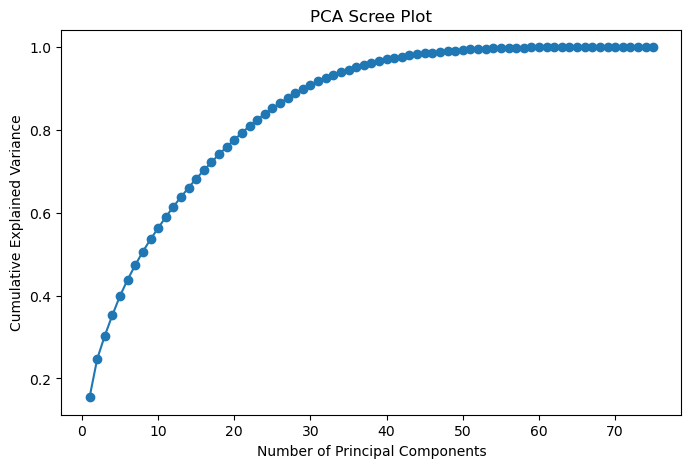

In [76]:
features = [col for col in df.columns if col not in ["car_ID", "CarName"]]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 完整 PCA，用于碎石图
pca_full = PCA()
pca_full.fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.show()

In [77]:
pca = PCA(n_components=16, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of principal components retained: {X_pca.shape[1]}")

pc_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca.to_csv("PCA/car_price_pca.csv", index=False)
print("Saved PCA results to PCA/car_price_pca.csv")

Number of principal components retained: 16
Saved PCA results to PCA/car_price_pca.csv


**AE**

Epoch [10/1500], Loss: 1.0073
Epoch [20/1500], Loss: 0.6457
Epoch [30/1500], Loss: 0.4718
Epoch [40/1500], Loss: 0.4895
Epoch [50/1500], Loss: 0.3097
Epoch [60/1500], Loss: 0.2372
Epoch [70/1500], Loss: 0.2072
Epoch [80/1500], Loss: 0.1614
Epoch [90/1500], Loss: 0.1377
Epoch [100/1500], Loss: 0.0950
Epoch [110/1500], Loss: 0.0882
Epoch [120/1500], Loss: 0.0702
Epoch [130/1500], Loss: 0.0728
Epoch [140/1500], Loss: 0.0629
Epoch [150/1500], Loss: 0.0512
Epoch [160/1500], Loss: 0.0608
Epoch [170/1500], Loss: 0.0464
Epoch [180/1500], Loss: 0.0440
Epoch [190/1500], Loss: 0.0472
Epoch [200/1500], Loss: 0.0388
Epoch [210/1500], Loss: 0.0378
Epoch [220/1500], Loss: 0.0313
Epoch [230/1500], Loss: 0.0345
Epoch [240/1500], Loss: 0.0359
Epoch [250/1500], Loss: 0.0285
Epoch [260/1500], Loss: 0.0289
Epoch [270/1500], Loss: 0.0275
Epoch [280/1500], Loss: 0.0243
Epoch [290/1500], Loss: 0.0217
Epoch [300/1500], Loss: 0.0235
Epoch [310/1500], Loss: 0.0238
Epoch [320/1500], Loss: 0.0223
Epoch [330/1500],

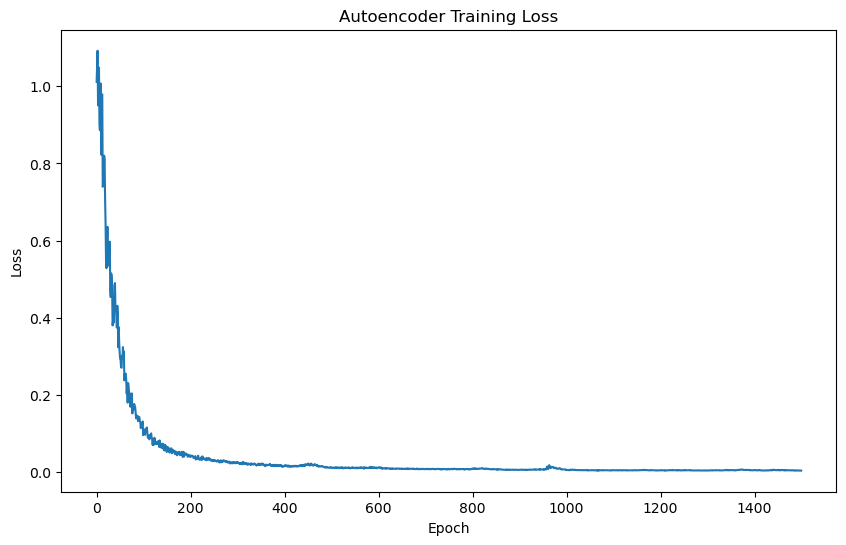

In [78]:
X_tensor = torch.FloatTensor(X_scaled)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),


            nn.Linear(128, input_dim)
            # 没有激活函数，默认回归输出（适配 MSE）
        )

    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model, loss function, optimizer, and learning rate scheduler
model = Autoencoder(X_scaled.shape[1], 16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1500
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        # Forward pass
        encoded, decoded = model(data)
        loss = criterion(decoded, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations
model.eval()
with torch.no_grad():
    encoded_data, _ = model(X_tensor)
    encoded_data = encoded_data.numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'AE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('AE/car_price_ae.csv', index=False)

**SAE**

Pretraining individual autoencoders...

Pretraining autoencoder 1
Epoch [20/1000], Loss: 0.5977
Epoch [40/1000], Loss: 0.3704
Epoch [60/1000], Loss: 0.2320
Epoch [80/1000], Loss: 0.1552
Epoch [100/1000], Loss: 0.1066
Epoch [120/1000], Loss: 0.0762
Epoch [140/1000], Loss: 0.0561
Epoch [160/1000], Loss: 0.0488
Epoch [180/1000], Loss: 0.0510
Epoch [200/1000], Loss: 0.0402
Epoch [220/1000], Loss: 0.0301
Epoch [240/1000], Loss: 0.0289
Epoch [260/1000], Loss: 0.0278
Epoch [280/1000], Loss: 0.0213
Epoch [300/1000], Loss: 0.0225
Epoch [320/1000], Loss: 0.0204
Epoch [340/1000], Loss: 0.0174
Epoch [360/1000], Loss: 0.0144
Epoch [380/1000], Loss: 0.0157
Epoch [400/1000], Loss: 0.0137
Epoch [420/1000], Loss: 0.0170
Epoch [440/1000], Loss: 0.0147
Epoch [460/1000], Loss: 0.0127
Epoch [480/1000], Loss: 0.0108
Epoch [500/1000], Loss: 0.0103
Epoch [520/1000], Loss: 0.0119
Epoch [540/1000], Loss: 0.0115
Epoch [560/1000], Loss: 0.0118
Epoch [580/1000], Loss: 0.0103
Epoch [600/1000], Loss: 0.0074
Epoch [6

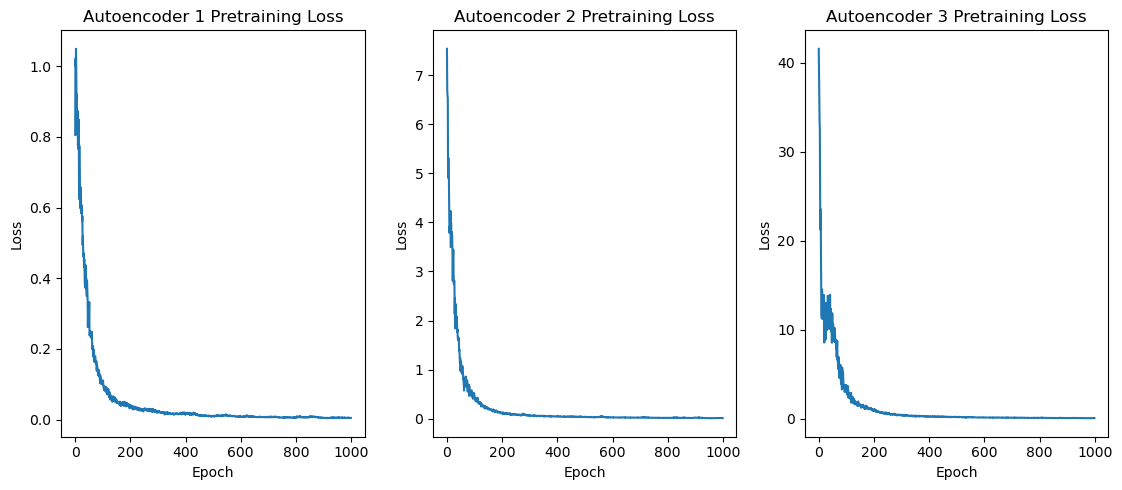


Fine-tuning complete model...
Epoch [10/1000], Loss: 0.0206
Epoch [20/1000], Loss: 0.0187
Epoch [30/1000], Loss: 0.0147
Epoch [40/1000], Loss: 0.0141
Epoch [50/1000], Loss: 0.0120
Epoch [60/1000], Loss: 0.0131
Epoch [70/1000], Loss: 0.0123
Epoch [80/1000], Loss: 0.0107
Epoch [90/1000], Loss: 0.0099
Epoch [100/1000], Loss: 0.0117
Epoch [110/1000], Loss: 0.0115
Epoch [120/1000], Loss: 0.0107
Epoch [130/1000], Loss: 0.0100
Epoch [140/1000], Loss: 0.0096
Epoch [150/1000], Loss: 0.0100
Epoch [160/1000], Loss: 0.0097
Epoch [170/1000], Loss: 0.0088
Epoch [180/1000], Loss: 0.0089
Epoch [190/1000], Loss: 0.0091
Epoch [200/1000], Loss: 0.0086
Epoch [210/1000], Loss: 0.0078
Epoch [220/1000], Loss: 0.0087
Epoch [230/1000], Loss: 0.0080
Epoch [240/1000], Loss: 0.0075
Epoch [250/1000], Loss: 0.0078
Epoch [260/1000], Loss: 0.0075
Epoch [270/1000], Loss: 0.0082
Epoch [280/1000], Loss: 0.0074
Epoch [290/1000], Loss: 0.0077
Epoch [300/1000], Loss: 0.0079
Epoch [310/1000], Loss: 0.0070
Epoch [320/1000],

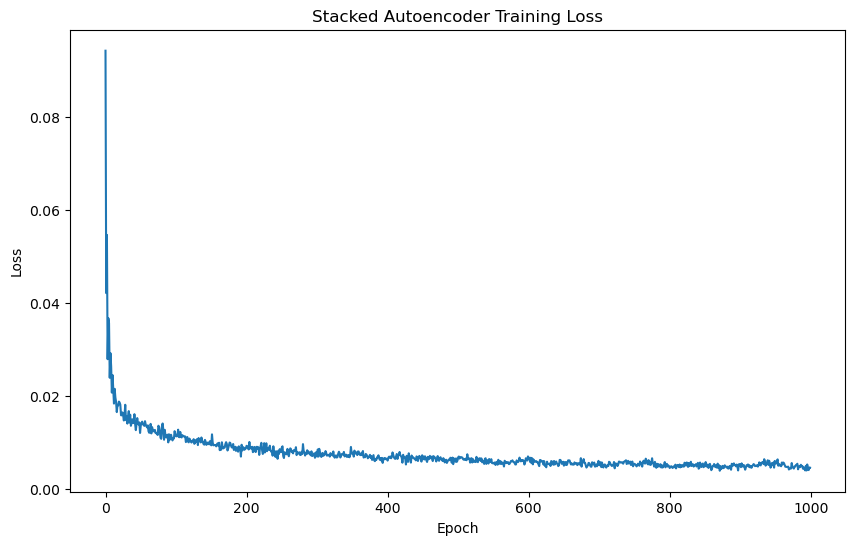

In [79]:
class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dims):
        super(StackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Create stack of autoencoders
        curr_dim = input_dim
        for encoding_dim in encoding_dims:
            self.autoencoders.append(Autoencoder(curr_dim, encoding_dim))
            curr_dim = encoding_dim
            
    def forward(self, x):
        encoded = x
        encoded_features = []
        for autoencoder in self.autoencoders:
            encoded = autoencoder.encoder(encoded)
            encoded_features.append(encoded)
            
        # Decode in reverse order
        decoded = encoded
        for autoencoder in reversed(self.autoencoders):
            decoded = autoencoder.decoder(decoded)
            
        return decoded, encoded_features

encoding_dims = [256,128,16]  # Progressive reduction in dimensions

model = StackedAutoencoder(X_scaled.shape[1], encoding_dims)
criterion = nn.MSELoss()

# Pretrain each autoencoder layer
print("Pretraining individual autoencoders...")
curr_input = X_tensor
pretrain_losses = []  # To store losses for each autoencoder
for i, autoencoder in enumerate(model.autoencoders):
    print(f"\nPretraining autoencoder {i+1}")
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    
    pretrain_epochs = 1000
    losses = []  # Store losses for the current autoencoder
    for epoch in range(pretrain_epochs):
        for data, _ in dataloader:
            if i > 0:
                with torch.no_grad():
                    for j in range(i):
                        data = model.autoencoders[j].encoder(data)
            
            encoded = autoencoder.encoder(data)
            decoded = autoencoder.decoder(encoded)
            loss = criterion(decoded, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{pretrain_epochs}], Loss: {loss.item():.4f}')
    
    pretrain_losses.append(losses)  # Store losses for plotting

# Plot pretraining losses for each autoencoder
plt.figure(figsize=(15, 5))
for i, losses in enumerate(pretrain_losses):
    plt.subplot(1, 4, i + 1)
    plt.plot(losses)
    plt.title(f'Autoencoder {i + 1} Pretraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# Fine-tune the entire model
print("\nFine-tuning complete model...")
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        decoded, encoded_features = model(data)
        loss = criterion(decoded, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Stacked Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations (using the final encoding layer)
model.eval()
with torch.no_grad():
    _, encoded_features = model(X_tensor)
    # Get the final encoded representation (32 dimensions)
    encoded_data = encoded_features[-1].numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'SAE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('SAE/car_price_sae.csv', index=False)